# Notebook for GSEA analysis of DEA output CORE vs BORDER genes in BRAIN organoids

#### import packages and data

In [1]:
import decoupler as dc
import omnipath as   op

In [6]:
dc.__version__

'1.6.0'

In [10]:
import pydeseq2
pydeseq2.__version__

'0.4.11'

In [2]:
import anndata as ad

In [3]:
import gseapy as gp

In [4]:
import numpy as np
import scanpy as sc
import seaborn as sns

In [5]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
# Point to your uploaded font
font_path = "./fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'Arial'

In [7]:
adata_r1 = ad.read('/group/neur6/jupyterlab/spatial/r1_ctrl_subset.h5ad')
adata_r2= ad.read('/group/neur6/jupyterlab/spatial/r2_hetero_subset.h5ad')
adata_r3 = ad.read('/group/neur6/jupyterlab/spatial/r3_ko_subset.h5ad')

#### Pseudobulk

In [8]:
adata_r1.obs['sample']='r1'
adata_r2.obs['sample']='r2'
adata_r3.obs['sample']='r3'

In [9]:
adata_tot=adata_r1.concatenate(adata_r2,adata_r3)

In [10]:
sample_colors = ['green', 'red', 'blue']  # Adjust colors as needed

# Assign the colors to `adata.uns`
adata_tot.uns['sample_colors'] = sample_colors


In [11]:
adata_tot.X = np.round(adata_tot.X)
adata_tot.layers['counts'] = adata_tot.X

pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

In [12]:
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)


# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)
sc.pl.pca(pdata, color=['region'], ncols=1, size=300,palette=['green', 'red', 'blue'] )

sc.pl.pca(pdata, color=['sample'], ncols=1, size=300,palette=[ 'gold','darkorange',
                                                                       'darkred'] )

In [13]:
pdata.obs['unit']=pdata.obs['region'].astype('str')+'_'+pdata.obs['sample'].astype('str')

In [14]:
pdata.obs['unit']=pdata.obs['unit'].astype('category')

In [15]:
sc.pl.correlation_matrix(pdata,'region')

ValueError: groupby has to be a categorical observation. Given value: region, Column type: object

In [ ]:
pdata=pdata[pdata.obs['region']!='edge']

/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


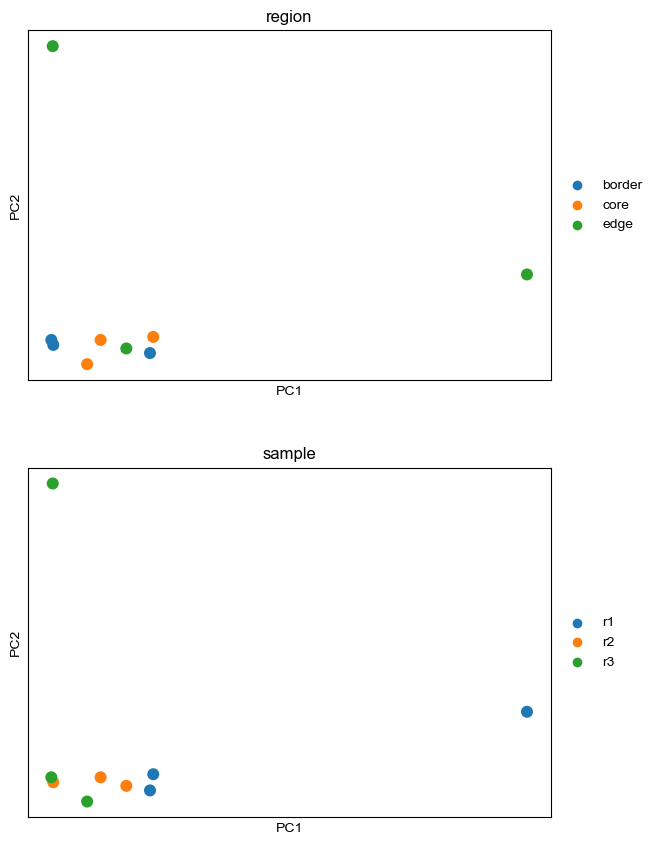

In [16]:
sc.pl.pca(pdata, color=['region','sample'], ncols=1, size=300)

In [17]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

#### Differential expression

In [18]:
pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata.layers['counts'] = pdata.X.copy()
from pydeseq2.dds import DeseqDataSet, DefaultInference

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='region',
    ref_level=['region', 'border'],
    refit_cooks=False, inference=inference,
)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.94 seconds.

Fitting dispersion trend curve...
/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...
... done in 0.96 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.41 seconds.



Log2 fold change & Wald test p-value: region core vs border
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        94.229890        0.542366  1.795357  0.302094  0.762581  0.999982
A1BG-AS1    55.161918       -0.056916  1.854366 -0.030693       NaN       NaN
A2ML1-AS1   55.800161        1.324567  2.088915  0.634093  0.526020  0.999982
A2MP1      109.160282       -0.263335  0.318519 -0.826749  0.408379  0.999982
AAAS       140.329268        0.007928  0.547731  0.014475  0.988451  0.999982
...               ...             ...       ...       ...       ...       ...
ZXDB        61.778795        0.057685  1.909529  0.030209  0.975900  0.999982
ZXDC       173.367723        0.942687  0.454651  2.073430  0.038132  0.999982
ZYG11B     185.173150       -0.083861  0.482316 -0.173872  0.861966  0.999982
ZYX        110.701275        0.159677  0.744826  0.214381  0.830250  0.999982
ZZEF1      122.594613       -0.423870  0.742614 -0.570781  0.568148  0.999982

[12

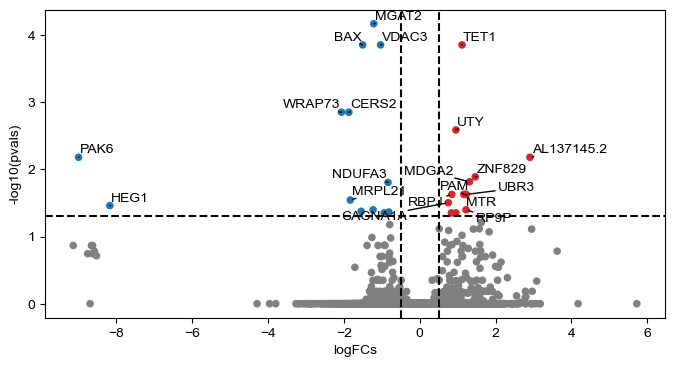

In [19]:
# Compute LFCs
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=["region", 'core', 'border'],
    inference=inference,
)
# Compute Wald test
stat_res.summary()
results_df = stat_res.results_df
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/vulcanobrain.svg',dpi=300)


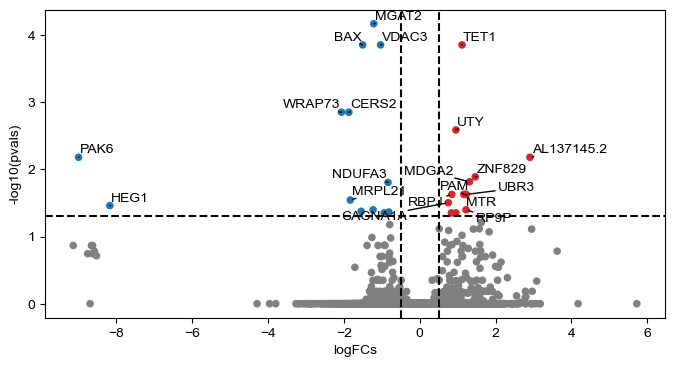

In [21]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/FIG3_E_volcanobrain',dpi=300)


In [22]:
results_df_adj=results_df[results_df['padj']<0.05]
results_core=results_df_adj[results_df_adj['log2FoldChange']>0]
results_core=results_core.sort_values(by='log2FoldChange',ascending=False)
results_core.index

Index(['AL137145.2', 'ZNF829', 'MDGA2', 'UBR3', 'RP9P', 'MTR', 'PAM', 'TET1',
       'SLC24A5', 'UTY', 'RBPJ', 'NOL4', 'CACNA1A'],
      dtype='object')

In [23]:
results_border=results_df_adj[results_df_adj['log2FoldChange']<0]
results_border=results_border.sort_values(by='log2FoldChange',ascending=True)
results_border.index

Index(['PAK6', 'HEG1', 'WRAP73', 'CERS2', 'MRPL21', 'NSMCE4A', 'BAX',
       'RPL26L1', 'MGAT2', 'VDAC3', 'STAM2', 'NDUFA3', 'NRDE2'],
      dtype='object')

In [24]:
mat = results_df[['stat']].T.rename(index={'stat': 'core'})
mat

,A1BG,A1BG-AS1,A2ML1-AS1,A2MP1,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,...,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
core,0.302094,-0.030693,0.634093,-0.826749,0.014475,2.208164,-0.050036,0.155055,0.956536,0.35124,...,-0.17621,-0.051686,0.625875,-0.33663,-1.08148,0.030209,2.07343,-0.173872,0.214381,-0.570781


#### GSEA

In [25]:
samples=list(pdata.obs.index)
genes=list(pdata.var.index)
gseainp=pd.DataFrame(pdata.X.T)
gseainp.columns=samples
gseainp.index=genes
gseainp

,r1_border,r2_border,r3_border,r1_core,r2_core,r3_core,r1_edge,r2_edge,r3_edge
A1BG,110.0,270.0,207.0,56.0,191.0,158.0,0.0,143.0,0.0
A1BG-AS1,45.0,112.0,144.0,0.0,169.0,0.0,34.0,34.0,37.0
A2ML1-AS1,112.0,154.0,53.0,193.0,165.0,0.0,0.0,18.0,0.0
A2MP1,234.0,368.0,184.0,83.0,88.0,123.0,36.0,71.0,63.0
AAAS,251.0,396.0,356.0,124.0,240.0,123.0,51.0,25.0,88.0
...,...,...,...,...,...,...,...,...,...
ZXDB,218.0,46.0,68.0,0.0,139.0,71.0,60.0,29.0,0.0
ZXDC,251.0,314.0,257.0,180.0,401.0,198.0,36.0,71.0,122.0
ZYG11B,496.0,368.0,252.0,187.0,168.0,148.0,109.0,131.0,63.0
ZYX,126.0,488.0,226.0,56.0,272.0,111.0,11.0,110.0,31.0


In [26]:
df2 = gseainp.filter(regex='^(?!.*edge).+')
df2

,r1_border,r2_border,r3_border,r1_core,r2_core,r3_core
A1BG,110.0,270.0,207.0,56.0,191.0,158.0
A1BG-AS1,45.0,112.0,144.0,0.0,169.0,0.0
A2ML1-AS1,112.0,154.0,53.0,193.0,165.0,0.0
A2MP1,234.0,368.0,184.0,83.0,88.0,123.0
AAAS,251.0,396.0,356.0,124.0,240.0,123.0
...,...,...,...,...,...,...
ZXDB,218.0,46.0,68.0,0.0,139.0,71.0
ZXDC,251.0,314.0,257.0,180.0,401.0,198.0
ZYG11B,496.0,368.0,252.0,187.0,168.0,148.0
ZYX,126.0,488.0,226.0,56.0,272.0,111.0


In [27]:
rnk=pd.DataFrame(results_df.iloc[:,3])
rnk

,stat
A1BG,0.302094
A1BG-AS1,-0.030693
A2ML1-AS1,0.634093
A2MP1,-0.826749
AAAS,0.014475
...,...
ZXDB,0.030209
ZXDC,2.073430
ZYG11B,-0.173872
ZYX,0.214381


In [28]:
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets='/group/neur6/jupyterlab/c5.go.v2023.2.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2025-03-31 00:37:45,454 [INFO] Parsing data files for GSEA.............................
2025-03-31 00:37:45,655 [INFO] 2356 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-03-31 00:37:45,656 [INFO] 8105 gene_sets used for further statistical testing.....
2025-03-31 00:37:45,656 [INFO] Start to run GSEA...Might take a while..................
2025-03-31 00:39:40,078 [INFO] Congratulations. GSEApy runs successfully................



In [29]:
tb=pre_res.res2d.sort_values('NES',ascending=True)

In [30]:
terms = pre_res.res2d.Term

#### Genes negatively enriched in the Core

In [31]:
tb.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT,-0.724623,-2.973233,0.0,0.0,0.0,52/94,11.03%,NDUFA3;SDHC;DNAJC15;NDUFB4;MT-CO2;SDHA;NDUFB6;...
1,prerank,GOBP_OXIDATIVE_PHOSPHORYLATION,-0.679598,-2.92556,0.0,0.0,0.0,68/131,11.03%,NDUFA3;SDHC;DNAJC15;ATP5F1C;ATP5F1E;NDUFB4;STO...
2,prerank,GOMF_OXIDOREDUCTION_DRIVEN_ACTIVE_TRANSMEMBRAN...,-0.746217,-2.899419,0.0,0.0,0.0,38/65,11.03%,NDUFA3;NDUFB4;MT-CO2;NDUFB6;MT-CO1;NDUFS8;MTCO...
3,prerank,GOCC_RESPIRASOME,-0.688213,-2.831005,0.0,0.0,0.0,48/92,11.03%,NDUFA3;SDHC;NDUFB4;MT-CO2;SDHA;NDUFB6;MT-CO1;N...
4,prerank,GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS,-0.699831,-2.752965,0.0,0.0,0.0,40/71,10.97%,NDUFA3;SDHC;ATP5F1C;ATP5F1E;NDUFB4;STOML2;SDHA...
5,prerank,GOMF_ELECTRON_TRANSFER_ACTIVITY,-0.664108,-2.751574,0.0,0.0,0.0,46/93,11.69%,NDUFA3;SDHC;NDUFB4;MT-CO2;SDHA;IDH3B;NDUFB6;MT...
6,prerank,GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN,-0.648604,-2.741334,0.0,0.0,0.0,53/111,11.03%,NDUFA3;SDHC;DNAJC15;NDUFB4;MT-CO2;SDHA;NDUFB6;...
7,prerank,GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX,-0.618861,-2.714531,0.0,0.0,0.0,66/145,11.61%,NDUFA3;SDHC;DNAJC15;ATP5F1C;ATP5F1E;NDUFB4;SAM...
8,prerank,GOBP_ELECTRON_TRANSPORT_CHAIN,-0.595061,-2.618411,0.0,0.0,0.0,59/141,11.69%,NDUFA3;SDHC;DNAJC15;NDUFB4;MT-CO2;SDHA;IDH3B;N...
9,prerank,GOBP_AEROBIC_RESPIRATION,-0.582401,-2.617577,0.0,0.0,0.0,73/174,11.03%,NDUFA3;SDHC;DNAJC15;ATP5F1C;ATP5F1E;NDUFB4;STO...


#### Genes positively enriched in the Core

In [32]:
tb.tail(15)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
56,prerank,GOBP_REGULATION_OF_MIRNA_TRANSCRIPTION,0.619278,2.053158,0.0,0.008101,0.108,13/36,10.35%,POU2F1;SMAD1;SREBF1;PPARA;FGF2;STAT3;FOXO3;SRE...
54,prerank,GOBP_GLUCOSE_CATABOLIC_PROCESS,0.760841,2.065068,0.0,0.007595,0.093,12/17,14.18%,PFKP;PGK1;ENO1;ENO2;HK1;HK2;TPI1;PGAM1;PKM;PFK...
53,prerank,GOMF_DEMETHYLASE_ACTIVITY,0.646838,2.065898,0.0,0.008106,0.092,13/32,11.92%,UTY;KDM3A;KDM4B;KDM4C;KDM5B;KDM6A;KDM5A;KDM7A;...
51,prerank,GOBP_CARBOHYDRATE_CATABOLIC_PROCESS,0.512761,2.069306,0.0,0.008386,0.089,34/101,14.84%,PFKP;DDIT4;MAN2B1;GPI;PGK1;LDHA;ENO1;ENO2;HK1;...
50,prerank,GOMF_PROTEIN_DEMETHYLASE_ACTIVITY,0.67939,2.07657,0.0,0.008113,0.078,11/25,11.92%,UTY;KDM3A;KDM4B;KDM4C;KDM5B;KDM6A;KDM5A;KDM7A;...
48,prerank,GOBP_GLYCOLYTIC_PROCESS_THROUGH_GLUCOSE_6_PHOS...,0.802129,2.115458,0.0,0.004177,0.039,11/15,12.87%,PFKP;PGK1;ENO1;ENO2;HK1;HK2;TPI1;PGAM1;PKM;PFK...
47,prerank,GOBP_REGULATION_OF_MIRNA_METABOLIC_PROCESS,0.603142,2.120343,0.0,0.004008,0.035,19/48,15.46%,POU2F1;SMAD1;KCNQ1OT1;SREBF1;PPARA;FGF2;STAT3;...
41,prerank,GOBP_GLYCOLYTIC_PROCESS,0.592948,2.185817,0.0,0.001424,0.01,28/61,14.18%,PFKP;DDIT4;GPI;PGK1;LDHA;ENO1;ENO2;HK1;HDAC4;A...
39,prerank,GOMF_DIOXYGENASE_ACTIVITY,0.606569,2.214157,0.0,0.000814,0.005,20/61,10.89%,TET1;UTY;KDM3A;KDM4B;ASPH;KDM4C;KDM5B;PLOD2;P4...
36,prerank,GOBP_PYRUVATE_METABOLIC_PROCESS,0.579405,2.219595,0.0,0.000791,0.004,32/79,12.87%,PFKP;SLC16A3;DDIT4;GPI;PDK1;PGK1;LDHA;ENO1;ENO...


In [33]:
list(tb.head(15)['Term'])

['GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT',
 'GOBP_OXIDATIVE_PHOSPHORYLATION',
 'GOMF_OXIDOREDUCTION_DRIVEN_ACTIVE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY',
 'GOCC_RESPIRASOME',
 'GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS',
 'GOMF_ELECTRON_TRANSFER_ACTIVITY',
 'GOBP_RESPIRATORY_ELECTRON_TRANSPORT_CHAIN',
 'GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX',
 'GOBP_ELECTRON_TRANSPORT_CHAIN',
 'GOBP_AEROBIC_RESPIRATION',
 'GOBP_MITOCHONDRIAL_ELECTRON_TRANSPORT_NADH_TO_UBIQUINONE',
 'GOCC_MITOCHONDRIAL_PROTEIN_CONTAINING_COMPLEX',
 'GOCC_CYTOCHROME_COMPLEX',
 'GOBP_PROTON_TRANSMEMBRANE_TRANSPORT',
 'GOCC_NADH_DEHYDROGENASE_COMPLEX']

In [34]:
list(tb.tail(15)['Term'])

['GOBP_REGULATION_OF_MIRNA_TRANSCRIPTION',
 'GOBP_GLUCOSE_CATABOLIC_PROCESS',
 'GOMF_DEMETHYLASE_ACTIVITY',
 'GOBP_CARBOHYDRATE_CATABOLIC_PROCESS',
 'GOMF_PROTEIN_DEMETHYLASE_ACTIVITY',
 'GOBP_GLYCOLYTIC_PROCESS_THROUGH_GLUCOSE_6_PHOSPHATE',
 'GOBP_REGULATION_OF_MIRNA_METABOLIC_PROCESS',
 'GOBP_GLYCOLYTIC_PROCESS',
 'GOMF_DIOXYGENASE_ACTIVITY',
 'GOBP_PYRUVATE_METABOLIC_PROCESS',
 'GOBP_POSITIVE_REGULATION_OF_MIRNA_TRANSCRIPTION',
 'GOBP_MONOSACCHARIDE_CATABOLIC_PROCESS',
 'GOBP_POSITIVE_REGULATION_OF_MIRNA_METABOLIC_PROCESS',
 'GOBP_HEXOSE_CATABOLIC_PROCESS',
 'GOMF_2_OXOGLUTARATE_DEPENDENT_DIOXYGENASE_ACTIVITY']

In [35]:
def round_to_2_sig_figs(x):
    if isinstance(x, float):
        return float(f"{x:.2g}")
    return x

### Plots

axs = pre_res.plot(terms=list(tb.head(10)['Term']))

fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseabrain1.svg',
            dpi=300, bbox_inches="tight")
plt.show()
#legend
subset_gsea = tb[tb['Term'].isin(list(tb.head(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.head(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseabrain1legend.svg',dpi=300,
         bbox_inches="tight"  )

plt.show()

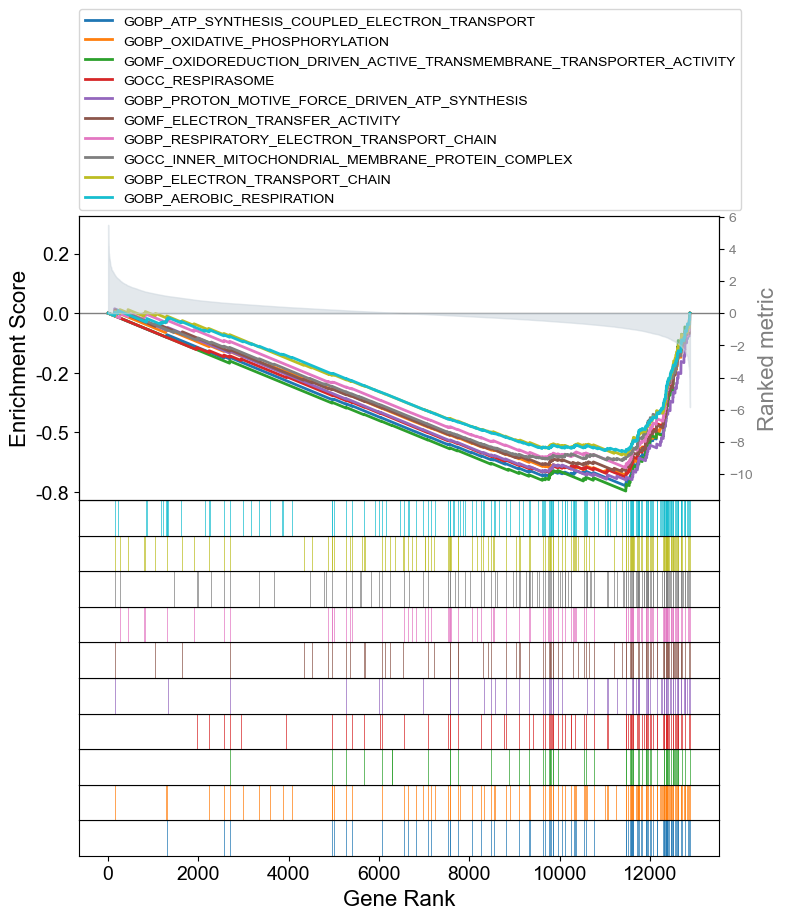

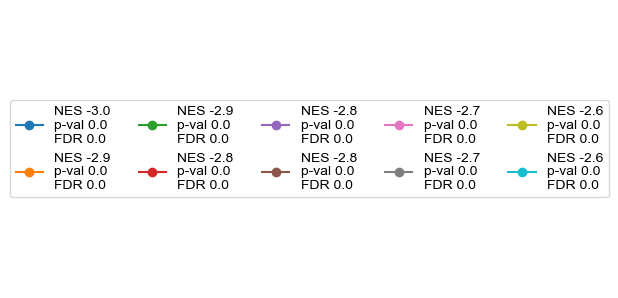

In [38]:
axs = pre_res.plot(terms=list(tb.head(10)['Term']))

fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/Fig3_F_GSEABrain.pdf',
            dpi=300, bbox_inches="tight")
plt.show()
#legend
subset_gsea = tb[tb['Term'].isin(list(tb.head(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.head(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/FIG3_F_legend',dpi=300,
         bbox_inches="tight"  )

plt.show()

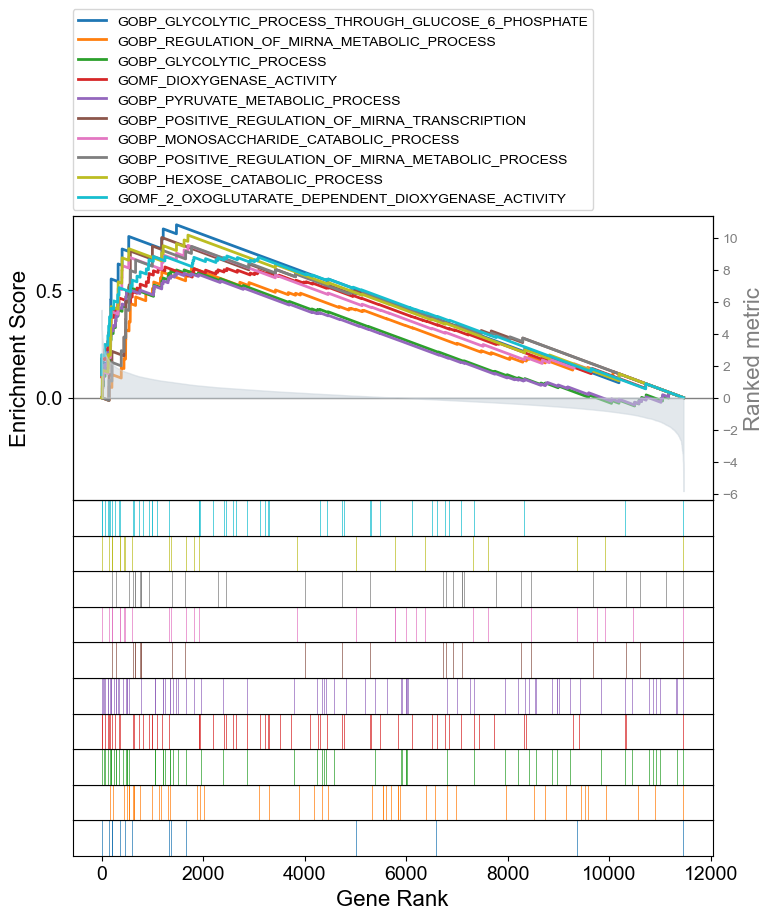

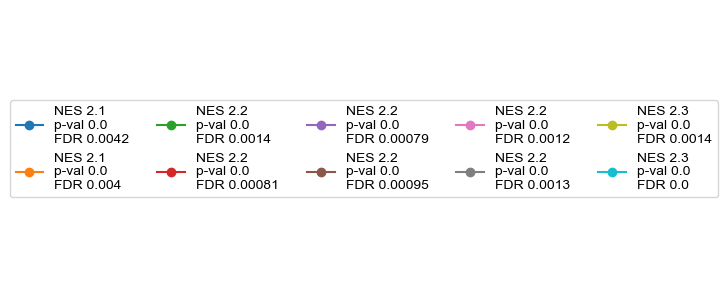

In [41]:
axs = pre_res.plot(terms=list(tb.tail(10)['Term']))

fig = axs.get_figure()
fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/Fig3_F_GSEABrain.pdf',
            dpi=300, bbox_inches="tight")
plt.show()
plt.show()

#fig.savefig('gsea_plot8terms_version2.svg', dpi=300, bbox_inches='tight')

#legend
subset_gsea = tb[tb['Term'].isin(list(tb.tail(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.tail(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")

fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/FIG3_F_legend.svg',
            dpi=300, bbox_inches="tight")
plt.show()


axs = pre_res.plot(terms=list(tb.tail(10)['Term']))

fig = axs.get_figure()
fig = axs.get_figure()
# Force width and height (e.g., 10 inches wide, 5 inches high)
fig.set_size_inches(8,8)

# Save with forced dimensions
fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseabrain2.svg',
            dpi=300, bbox_inches="tight")
plt.show()
plt.show()

#fig.savefig('gsea_plot8terms_version2.svg', dpi=300, bbox_inches='tight')

#legend
subset_gsea = tb[tb['Term'].isin(list(tb.tail(10)['Term']))].iloc[:,[1,3,4,5]]
subset_gsea = subset_gsea.applymap(round_to_2_sig_figs)
subset_gsea['Concatenated'] = subset_gsea.apply(lambda row: f"NES {row['NES']}\np-val {row['NOM p-val']}\nFDR {row['FDR q-val']}"
                                                , axis=1)

subset_gsea['Term'] = pd.Categorical(subset_gsea['Term'], categories=list(tb.tail(10)['Term']), ordered=True)

# Sort the DataFrame by the categorical column
subset_gsea = subset_gsea.sort_values('Term')

labels=list(subset_gsea['Concatenated'])
colors = plt.get_cmap('tab10').colors

# Create a figure and an axis
fig, ax = plt.subplots()

# Create dummy lines to include in the legend
lines = [ax.plot([], [], label=labels[i], color=colors[i], marker='o')[0] for i in range(len(labels))]

# Turn off the axis
ax.axis('off')

# Create the legend in the center of the plot
legend = ax.legend(handles=lines, loc='center', ncol=5)

# Adjust the figure to fit the legend
fig.subplots_adjust(bottom=0.3)
#plt.savefig("gsea_legend8terms_version2.pdf", format="pdf", bbox_inches="tight")

fig.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/gseabrain2legend.svg',
            dpi=300, bbox_inches="tight")
plt.show()
